In [ ]:
pip install kaggle

In [ ]:
! pip install -q kaggle
import os
if not os.path.isfile(os.path.expanduser('~/.kaggle/kaggle.json')):
  from google.colab import files
  print("Upload kaggle.json here")
  files.upload()

if not os.path.isfile('IMDB Dataset.csv'):
  !mkdir ~/.kaggle
  !mv ./kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  dataset_name = 'mohamedhanyyy/chest-ctscan-images'
  zip_name = dataset_name.split('/')[-1]

  !kaggle datasets download -d {dataset_name}
  !unzip -q ./{zip_name}.zip -d .


mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat './kaggle.json': No such file or directory
 95% 113M/119M [00:00<00:00, 184MB/s] 
100% 119M/119M [00:00<00:00, 167MB/s]


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3


import warnings
warnings.filterwarnings("ignore")

In [5]:
# File Directory for both the train and test
train_path = "/content/Data/train"
val_path = "/content/Data/valid"
test_path = "/content/Data/test"

In [6]:
# Define function to count number of images per class using a dictionary
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # count files in the folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

# Get the number of images per class in each set (train, validation and test)
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195} 

 {'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23} 

 {'adenocarcinoma': 120, 'squamous.cell.carcinoma': 90, 'large.cell.carcinoma': 51, 'normal': 54}


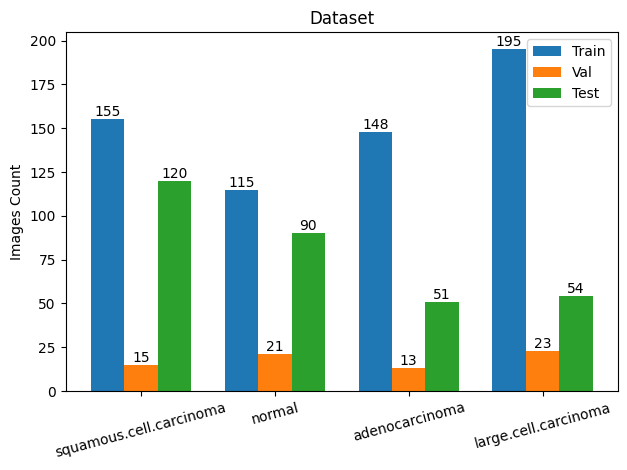

In [7]:
# Labels for each classs
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']

# Create lists from previous dictionaries storing the count of images per category
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

# Labels location and bars widht
x = np.arange(len(labels))
width = 0.25

# Create plot and 3 sets of bars (train, val, test)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add labels, title, legend, count values...
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()
ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

# Optimized layout and displaying plot
fig.tight_layout()
plt.show()

In [8]:
# Image data generator with specified augmentation configurations (mostly geometric transformations)
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

# Using data generator to create augmented data from image files in train_path directory
train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

# Dicctionary with class names to their respective indices in the generated data
train_data.class_indices

Found 613 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [9]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')
val_data.class_indices

Found 72 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [ ]:
{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [11]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')
test_data.class_indices

Found 315 images belonging to 4 classes.


{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [12]:
{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

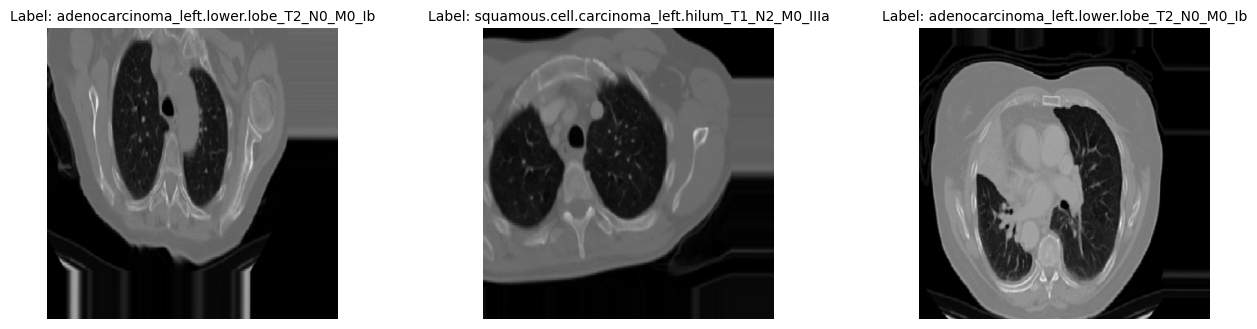

In [13]:
# Function to plot sample images with labels
def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    fig.subplots_adjust(wspace=0.5)  # Adjust the width space between subplots

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title("Label: {}".format(class_labels[np.argmax(labels[i])]), fontsize=10)  # Adjust fontsize as needed
        axs[i].axis('off')

    plt.show()

# Sample and plotting of 3 images with their respective labels from train_data
sample_images, sample_labels = next(train_data)
plot_sample_images(sample_images[:3], sample_labels[:3], train_data.class_indices)

In [14]:
base_model = EfficientNetB0(input_shape = (350, 350, 3),
                         include_top = False,
                         weights = 'imagenet')

In [15]:
mc = ModelCheckpoint(
    filepath="./ct_effnet_best_model.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );

call_back = [ mc];

tensorboard = TensorBoard(log_dir = 'logs')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

#We also add a earlystop for prevent the computer from wasting time if it's not making progress.


early_stopping = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)

In [16]:
#Customize our base model
EffNetmodel = base_model.output
EffNetmodel = tf.keras.layers.GlobalAveragePooling2D()(EffNetmodel)
# to provide overfitting problem
EffNetmodel = tf.keras.layers.Dropout(rate=0.5)(EffNetmodel)

#Finally, we add a layer with 4 'neurons' that will help us classify things into different categories.
EffNetmodel = tf.keras.layers.Dense(4,activation='softmax')(EffNetmodel)

In [17]:
#We put together the original EfficientNetB0 and our new custom parts
EffNetmodel = tf.keras.models.Model(inputs=base_model.input, outputs = EffNetmodel)

#Compile up the rules and tools for training your neural network.
#The optimizer determines how the model should update its internal parameters, the loss function quantifies how well the model is doing, and the metrics provide additional measures to track the model's performance.
EffNetmodel.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [18]:
%time
EffNetB0 = EffNetmodel.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size,
    epochs = 15,
    validation_data = val_data,
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = [tensorboard, mc, reduce_lr, early_stopping]
    )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
Epoch 1/15
122/122 [==============================] - ETA: 0s - loss: 1.1018 - accuracy: 0.4967
Epoch 1: val_accuracy improved from -inf to 0.32857, saving model to ./ct_effnet_best_model.hdf5


122/122 [==============================] - 395s 3s/step - loss: 1.1018 - accuracy: 0.4967 - val_loss: 1.5988 - val_accuracy: 0.3286 - lr: 0.0010
Epoch 2/15
122/122 [==============================] - ETA: 0s - loss: 0.9153 - accuracy: 0.6102
Epoch 2: val_accuracy did not improve from 0.32857


122/122 [==============================] - 368s 3s/step - loss: 0.9153 - accuracy: 0.6102 - val_loss: 9.0431 - val_accuracy: 0.1857 - lr: 0.0010
Epoch 3/15
122/122 [==============================] - ETA: 0s - loss: 0.7545 - accuracy: 0.6645
Epoch 3: val_accuracy did not improve from 0.32857

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.


122/122 [==============================] - 370s 3s/step - loss: 0.7545 - accuracy: 0.6645 - val_loss: 2.0699 - val_accuracy: 0.1857 - lr: 0.0010
Epoch 4/15
122/122 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.8059
Epoch 4: val_accuracy did not improve from 0.32857


122/122 [==============================] - 373s 3s/step - loss: 0.5108 - accuracy: 0.8059 - val_loss: 1.8498 - val_accuracy: 0.1857 - lr: 3.0000e-04
Epoch 5/15
122/122 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.8717
Epoch 5: val_accuracy did not improve from 0.32857

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.


122/122 [==============================] - 390s 3s/step - loss: 0.3671 - accuracy: 0.8717 - val_loss: 3.1311 - val_accuracy: 0.1714 - lr: 3.0000e-04
Epoch 6/15
122/122 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 0.8947
Epoch 6: val_accuracy did not improve from 0.32857


122/122 [==============================] - 393s 3s/step - loss: 0.2652 - accuracy: 0.8947 - val_loss: 2.3200 - val_accuracy: 0.1429 - lr: 9.0000e-05
Epoch 7/15
122/122 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.8964
Epoch 7: val_accuracy did not improve from 0.32857

Epoch 7: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.


122/122 [==============================] - 381s 3s/step - loss: 0.2609 - accuracy: 0.8964 - val_loss: 1.9899 - val_accuracy: 0.1857 - lr: 9.0000e-05
Epoch 8/15
122/122 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.9243
Epoch 8: val_accuracy improved from 0.32857 to 0.38571, saving model to ./ct_effnet_best_model.hdf5


122/122 [==============================] - 373s 3s/step - loss: 0.2346 - accuracy: 0.9243 - val_loss: 1.6805 - val_accuracy: 0.3857 - lr: 2.7000e-05
Epoch 9/15
122/122 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9441
Epoch 9: val_accuracy did not improve from 0.38571


122/122 [==============================] - 401s 3s/step - loss: 0.1739 - accuracy: 0.9441 - val_loss: 1.5709 - val_accuracy: 0.3143 - lr: 2.7000e-05
Epoch 10/15
122/122 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9309
Epoch 10: val_accuracy improved from 0.38571 to 0.48571, saving model to ./ct_effnet_best_model.hdf5


122/122 [==============================] - 367s 3s/step - loss: 0.1933 - accuracy: 0.9309 - val_loss: 1.1939 - val_accuracy: 0.4857 - lr: 2.7000e-05
Epoch 11/15
122/122 [==============================] - ETA: 0s - loss: 0.1902 - accuracy: 0.9309
Epoch 11: val_accuracy did not improve from 0.48571


122/122 [==============================] - 368s 3s/step - loss: 0.1902 - accuracy: 0.9309 - val_loss: 2.8931 - val_accuracy: 0.2143 - lr: 2.7000e-05
Epoch 12/15
122/122 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9309
Epoch 12: val_accuracy did not improve from 0.48571

Epoch 12: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.


122/122 [==============================] - 388s 3s/step - loss: 0.1738 - accuracy: 0.9309 - val_loss: 1.7413 - val_accuracy: 0.1714 - lr: 2.7000e-05
Epoch 13/15
122/122 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9408
Epoch 13: val_accuracy improved from 0.48571 to 0.52857, saving model to ./ct_effnet_best_model.hdf5


122/122 [==============================] - 381s 3s/step - loss: 0.1850 - accuracy: 0.9408 - val_loss: 0.9659 - val_accuracy: 0.5286 - lr: 8.1000e-06
Epoch 14/15
122/122 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9589
Epoch 14: val_accuracy improved from 0.52857 to 0.80000, saving model to ./ct_effnet_best_model.hdf5


122/122 [==============================] - 371s 3s/step - loss: 0.1477 - accuracy: 0.9589 - val_loss: 0.6891 - val_accuracy: 0.8000 - lr: 8.1000e-06
Epoch 15/15
122/122 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9490
Epoch 15: val_accuracy did not improve from 0.80000


122/122 [==============================] - 388s 3s/step - loss: 0.1569 - accuracy: 0.9490 - val_loss: 1.3303 - val_accuracy: 0.4143 - lr: 8.1000e-06


In [24]:
from tensorflow.keras.models import load_model




In [35]:
# Assuming you have trained and named your model 'model'
# model = your_model_training_function()

# Save the model
EffNetB0.save("lungcancer11.h5")

# Optionally, if you want to load the model later:
# loaded_model = load_model("lungcancer.h5")

AttributeError: 'History' object has no attribute 'save'

In [32]:
from tensorflow.keras.models import load_model

# Load the saved model
saved_model_path = "/content/ct_effnet_best_model.hdf5"
model = load_model(saved_model_path)

# Load and preprocess the new image data using the same data generator
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the new image data
img_path = '/content/Data/test/adenocarcinoma/000113 (7).png'  # Update with the path to your new image
img = image.load_img(img_path, target_size=(350, 350))  # Assuming your model expects input size of 350x350
img_array = image.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

# Preprocess the image using the same data generator
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=0.4)

# No need for augmentation, as we're dealing with a single image
img_generator = train_datagen.flow(img_array, batch_size=1)

# Now you can use the model to make predictions
predictions = model.predict(img_generator)

# Print the predictions
print(predictions)


1/1 [==============================] - 2s 2s/step
[[0.07060128 0.13108844 0.6625458  0.1357645 ]]


In [34]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
saved_model_path = "/content/ct_effnet_best_model.hdf5"
model = load_model(saved_model_path)

# Load and preprocess the new image data
img_path = '/content/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000009 (3).png'  # Update with the path to your new image
img = image.load_img(img_path, target_size=(350, 350))  # Assuming your model expects input size of 350x350
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale to [0, 1] range (assuming you rescaled images in the ImageDataGenerator)

# Now you can use the model to make predictions
predictions = model.predict(img_array)

# Get the class indices
class_indices = train_data.class_indices

# Invert the dictionary to map indices to class names
inverse_class_indices = dict((v, k) for k, v in class_indices.items())

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted class name
predicted_class_name = inverse_class_indices[predicted_class_index]

# Print the predicted class name
print("Predicted class:", predicted_class_name)


1/1 [==============================] - 2s 2s/step
Predicted class: normal


In [42]:
pip install pillow

In [45]:
from keras.preprocessing import image
import numpy as np
from PIL import Image
from google.colab import files

# Load and preprocess the image
def load_and_preprocess_image():
    # Prompt the user to upload a file
    uploaded = files.upload()

    # Get the path of the uploaded file
    for filename in uploaded.keys():
        image_path = filename

    # Load and preprocess the new image
    img = Image.open(image_path)
    img = img.resize((350, 350))  # Adjust the target size to match your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values to the range [0, 1]

    return img_array

# Load your own model
model = load_model("/content/ct_effnet_best_model.hdf5")  # Replace "your_model.h5" with the path to your model file

# Example usage:
new_image = load_and_preprocess_image()

# Assuming your model is loaded and named 'model'
predictions = model.predict(new_image)

# Process the predictions as needed for your application
predicted_class_index = np.argmax(predictions)
print("Predicted Class Index:", predicted_class_index)


Saving n8 - Copy.jpg to n8 - Copy.jpg
1/1 [==============================] - 2s 2s/step
Predicted Class Index: 2
